c:\Users\LENOVO\Documents\Paper\Penelitian-Skripsi-Cuaca\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🚀 [INIT] Memulai Analisis Data (Mode: Fixed)...
✅ [DATA] Total Sampel Bersih: 149 Mahasiswa.
📊 [TARGET] Batas Risiko Dinamis: IPK < 3.50

⚙️ [MODELING] Menjalankan Evaluasi Model...
   ✅ Data cukup. Menggunakan SMOTE.
   > Decision Tree: Akurasi 0.7253
   > Random Forest: Akurasi 0.7384
   > XGBoost: Akurasi 0.7046

🎨 [VISUAL] Membuat Grafik...

✅ [SELESAI] Analisis Berhasil! CSV Final Tersimpan.


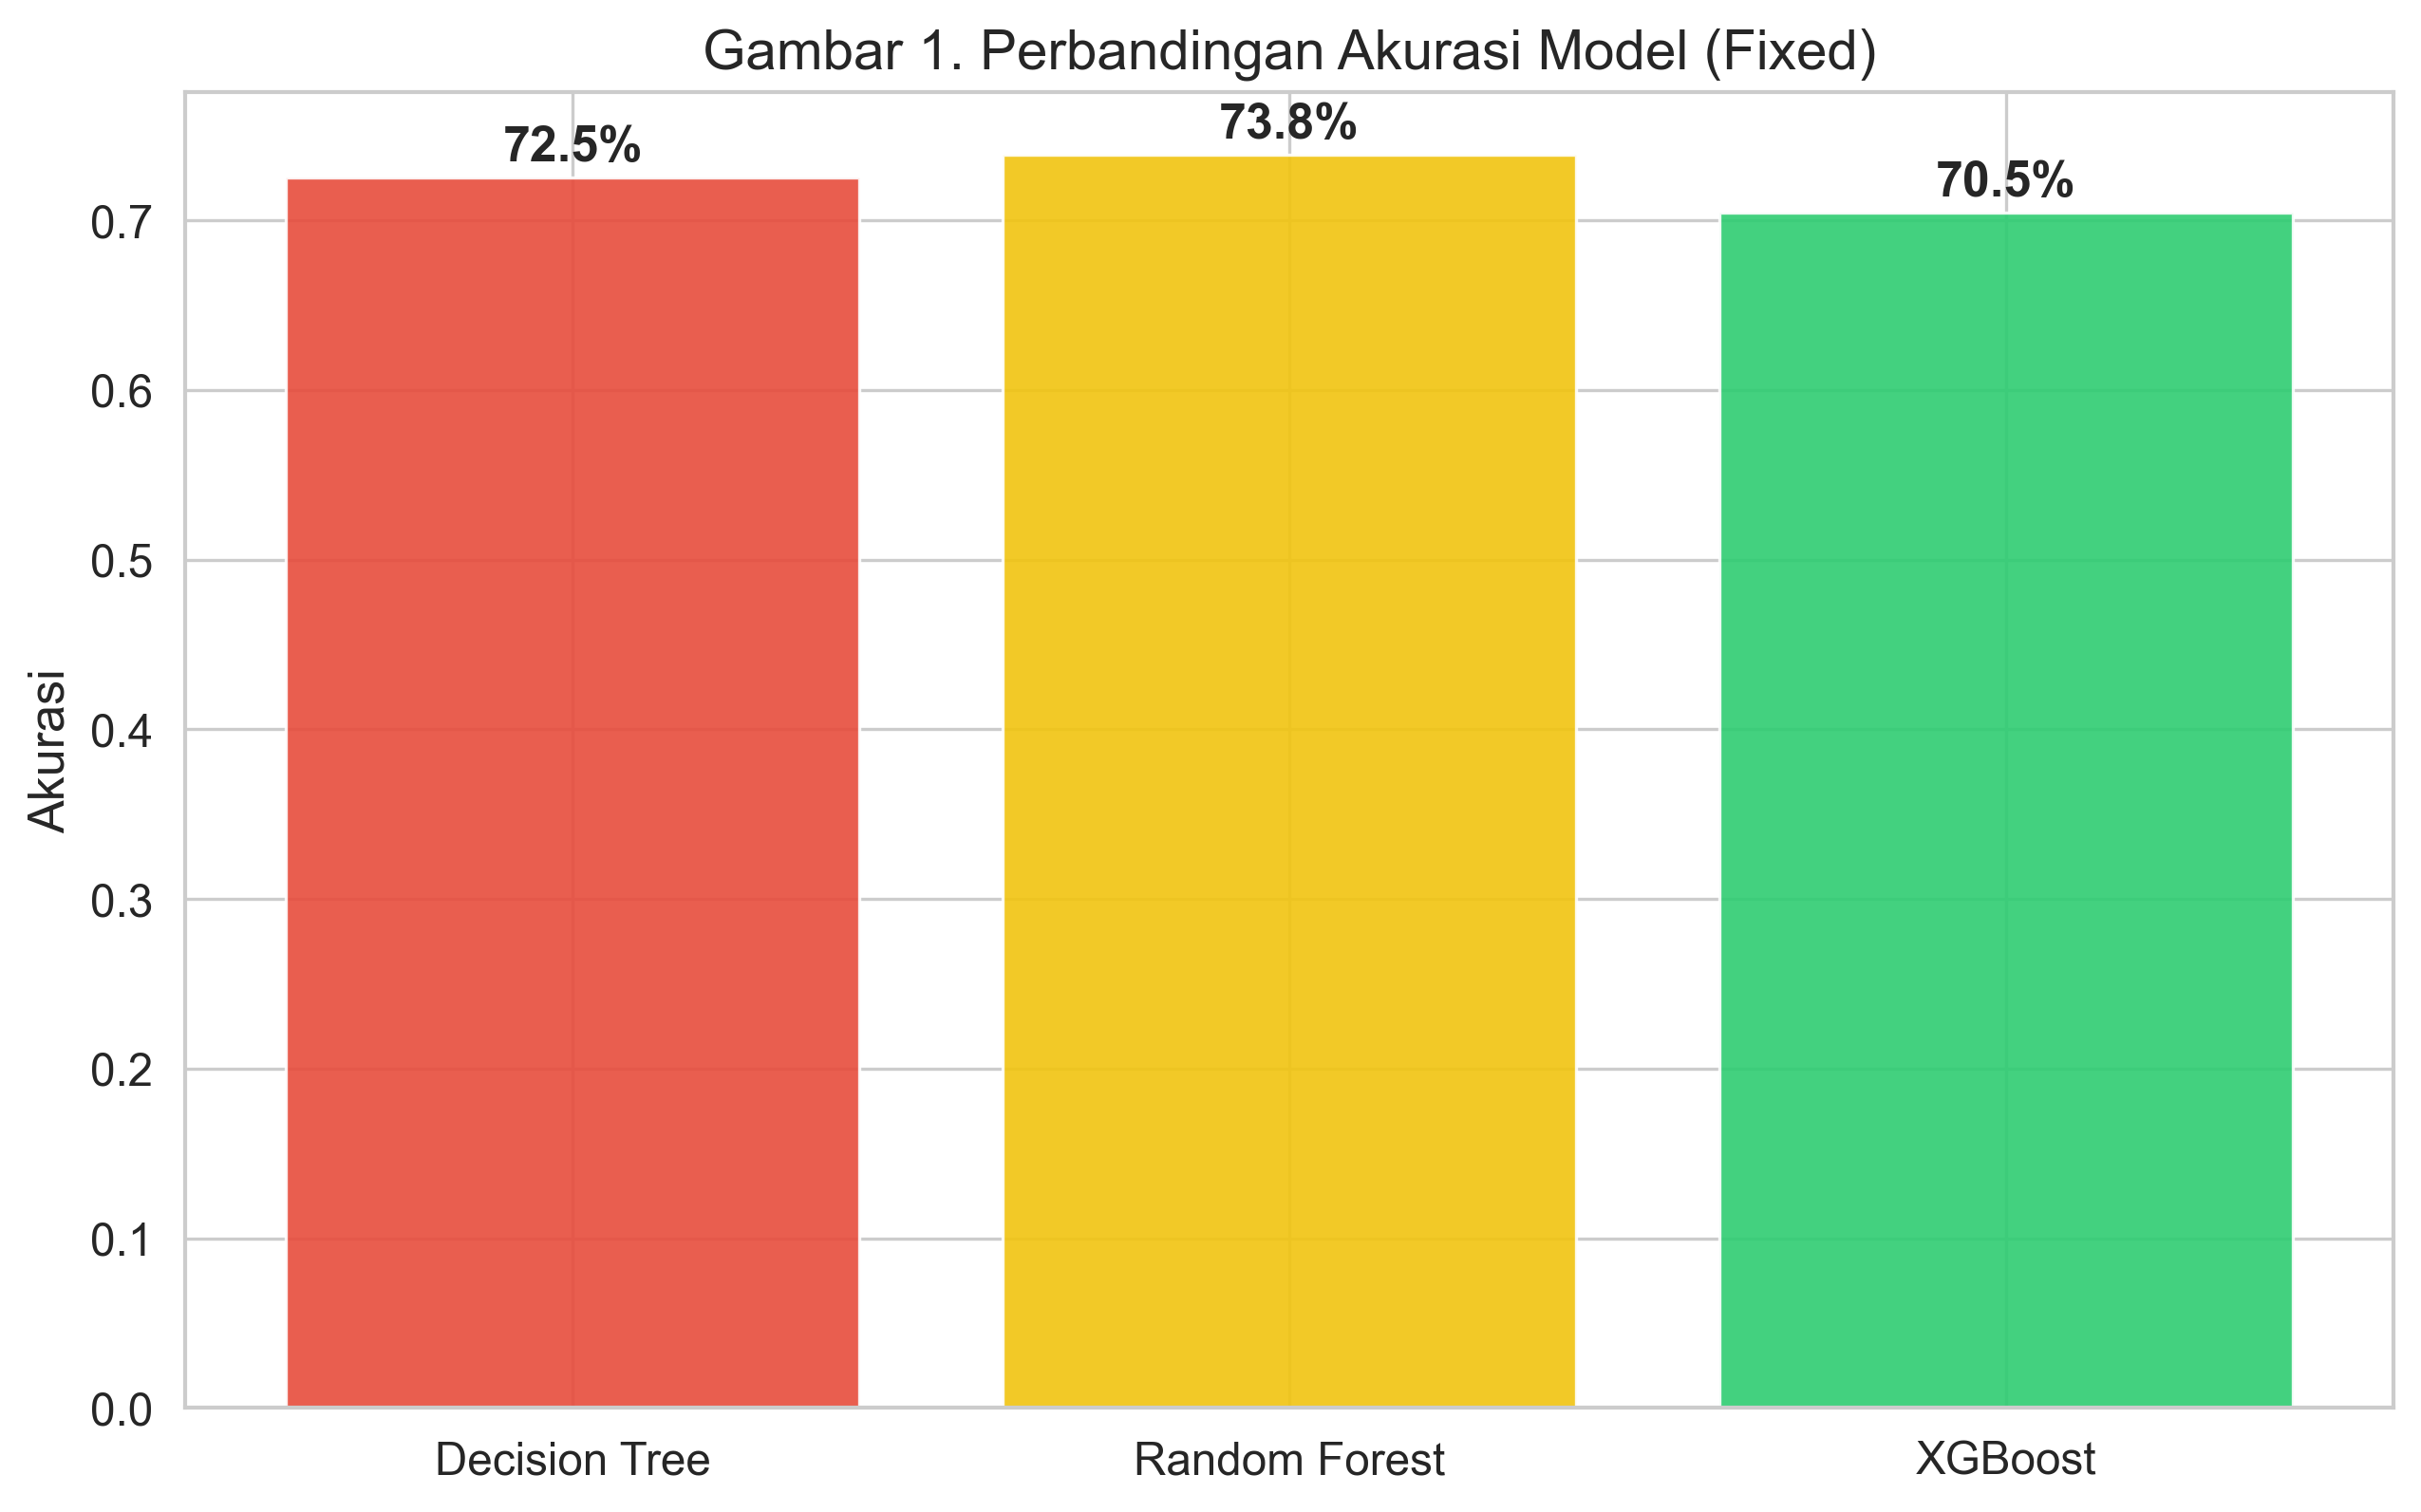

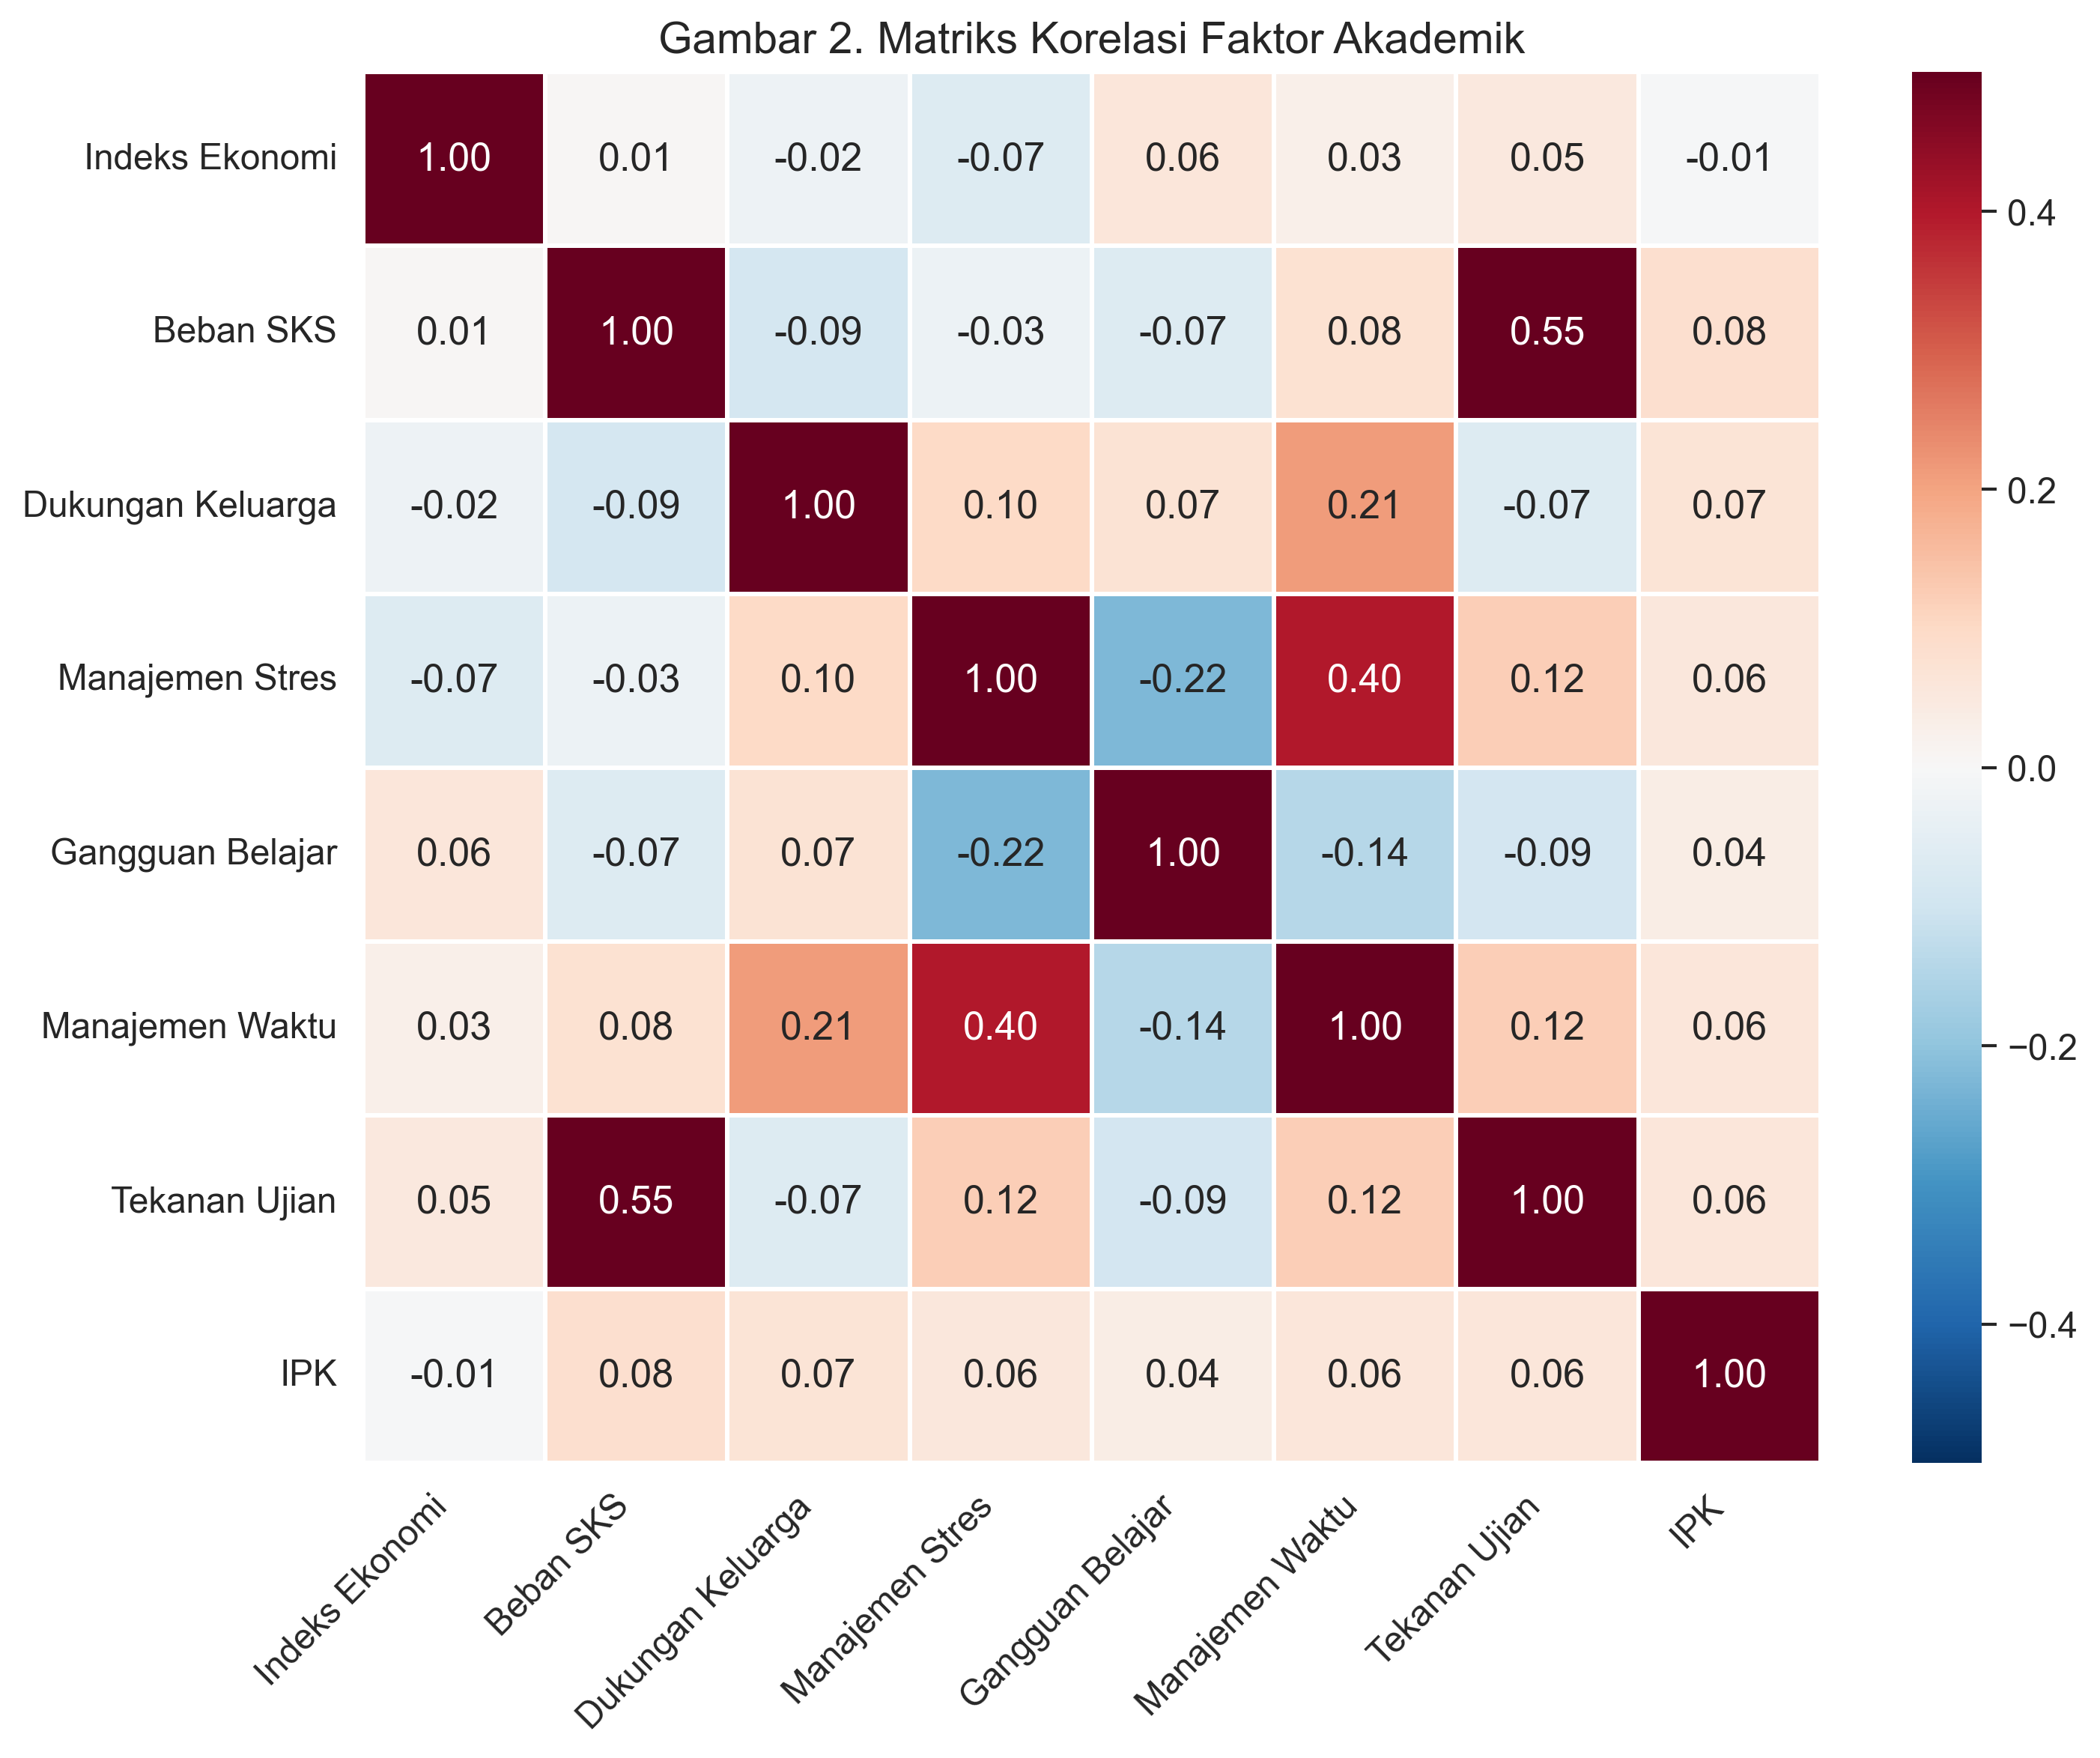

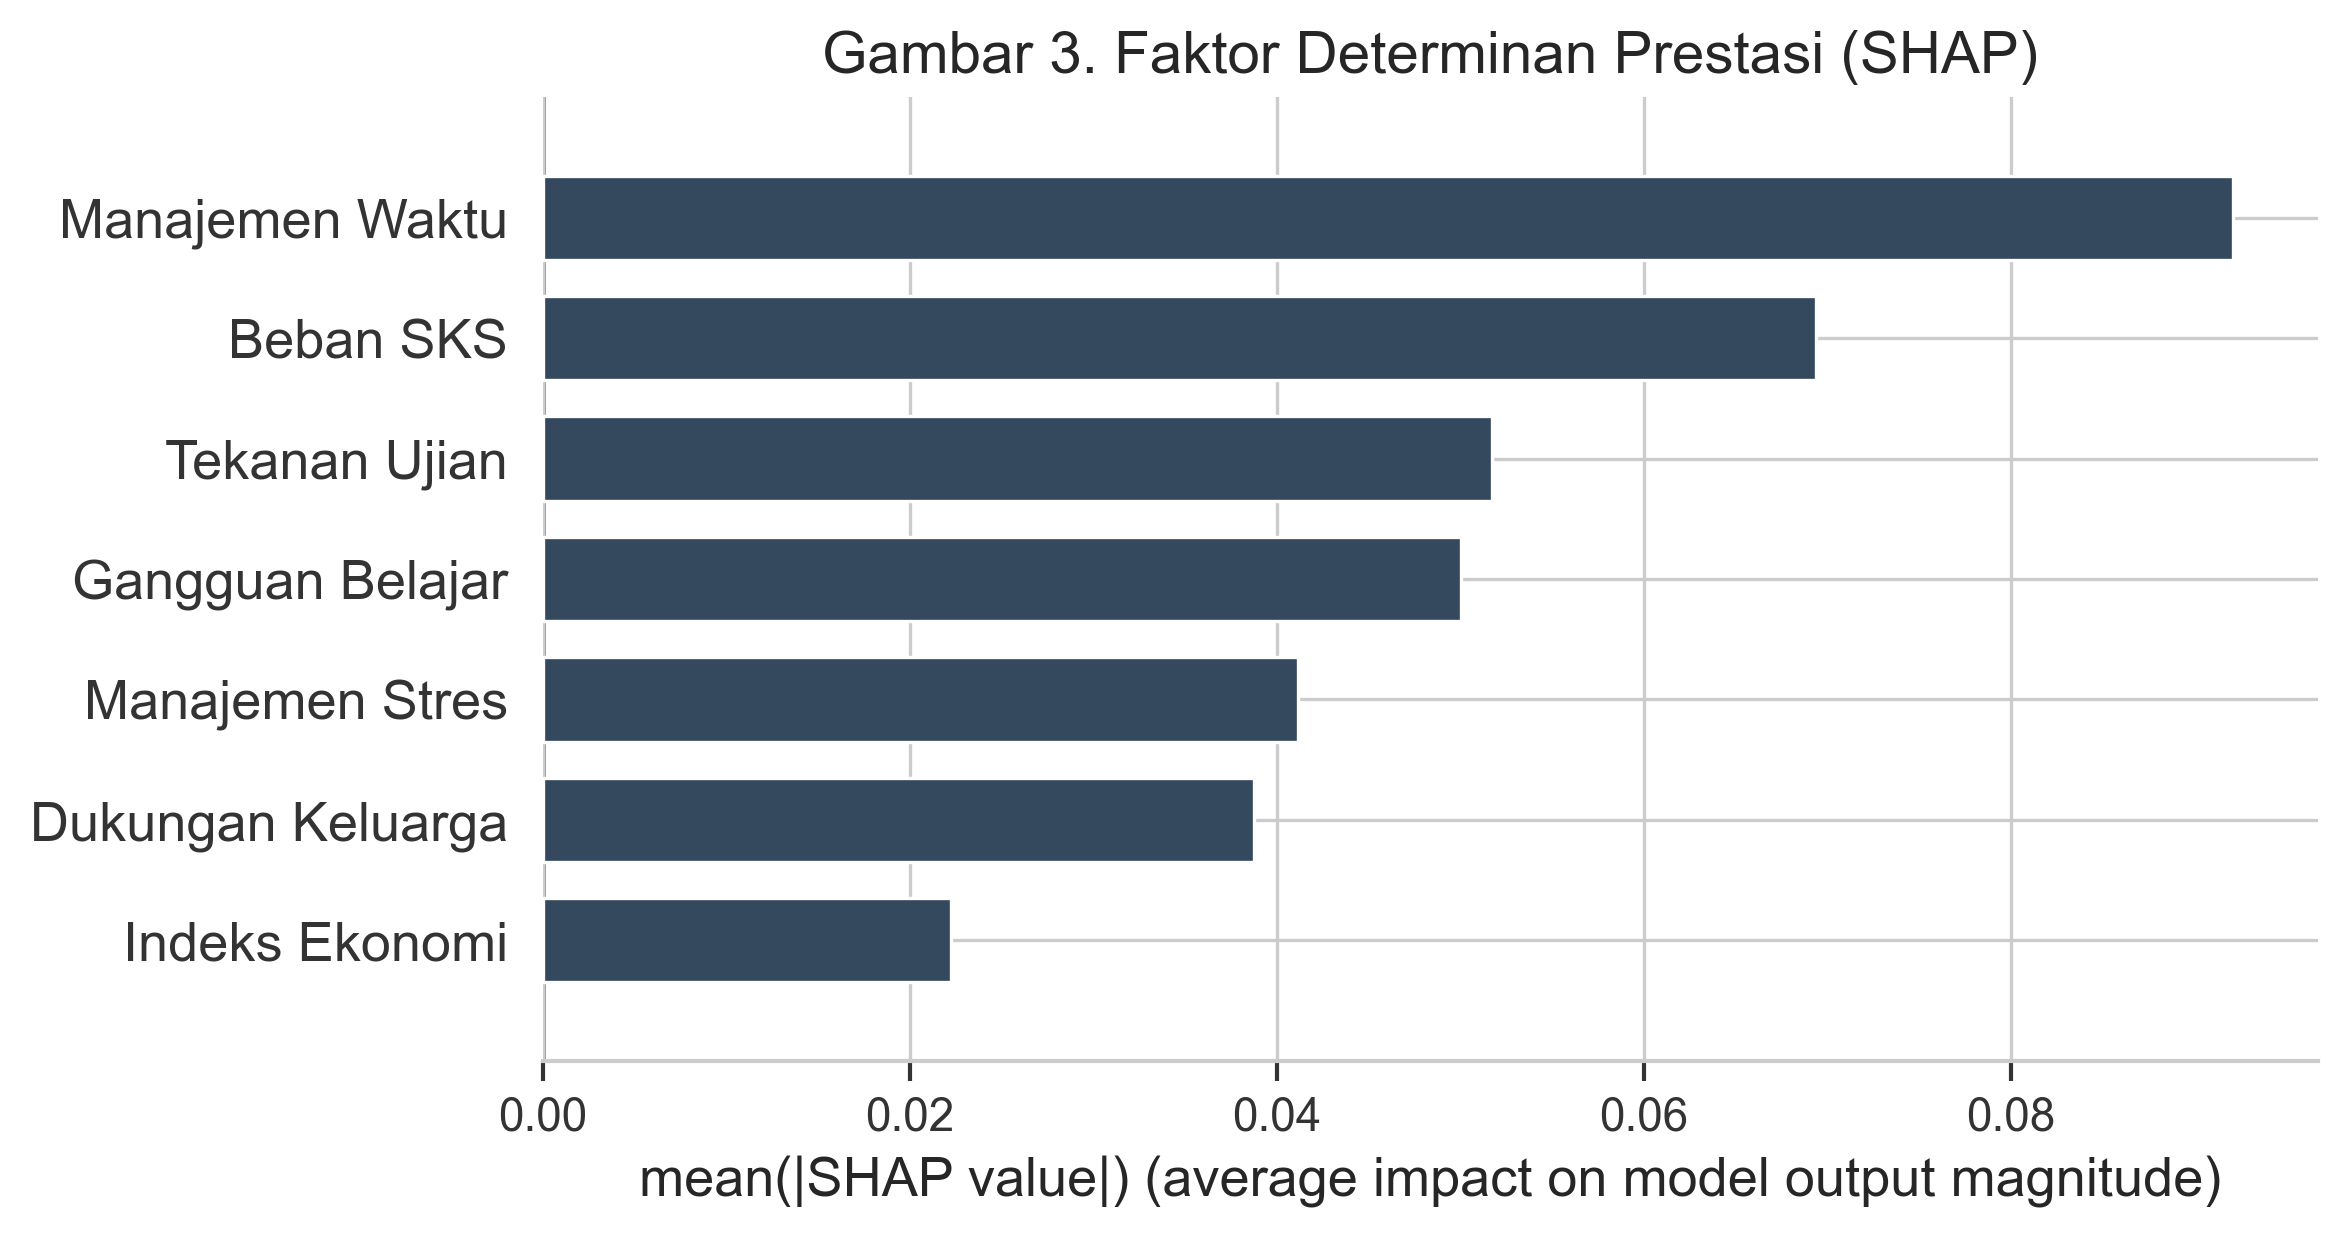

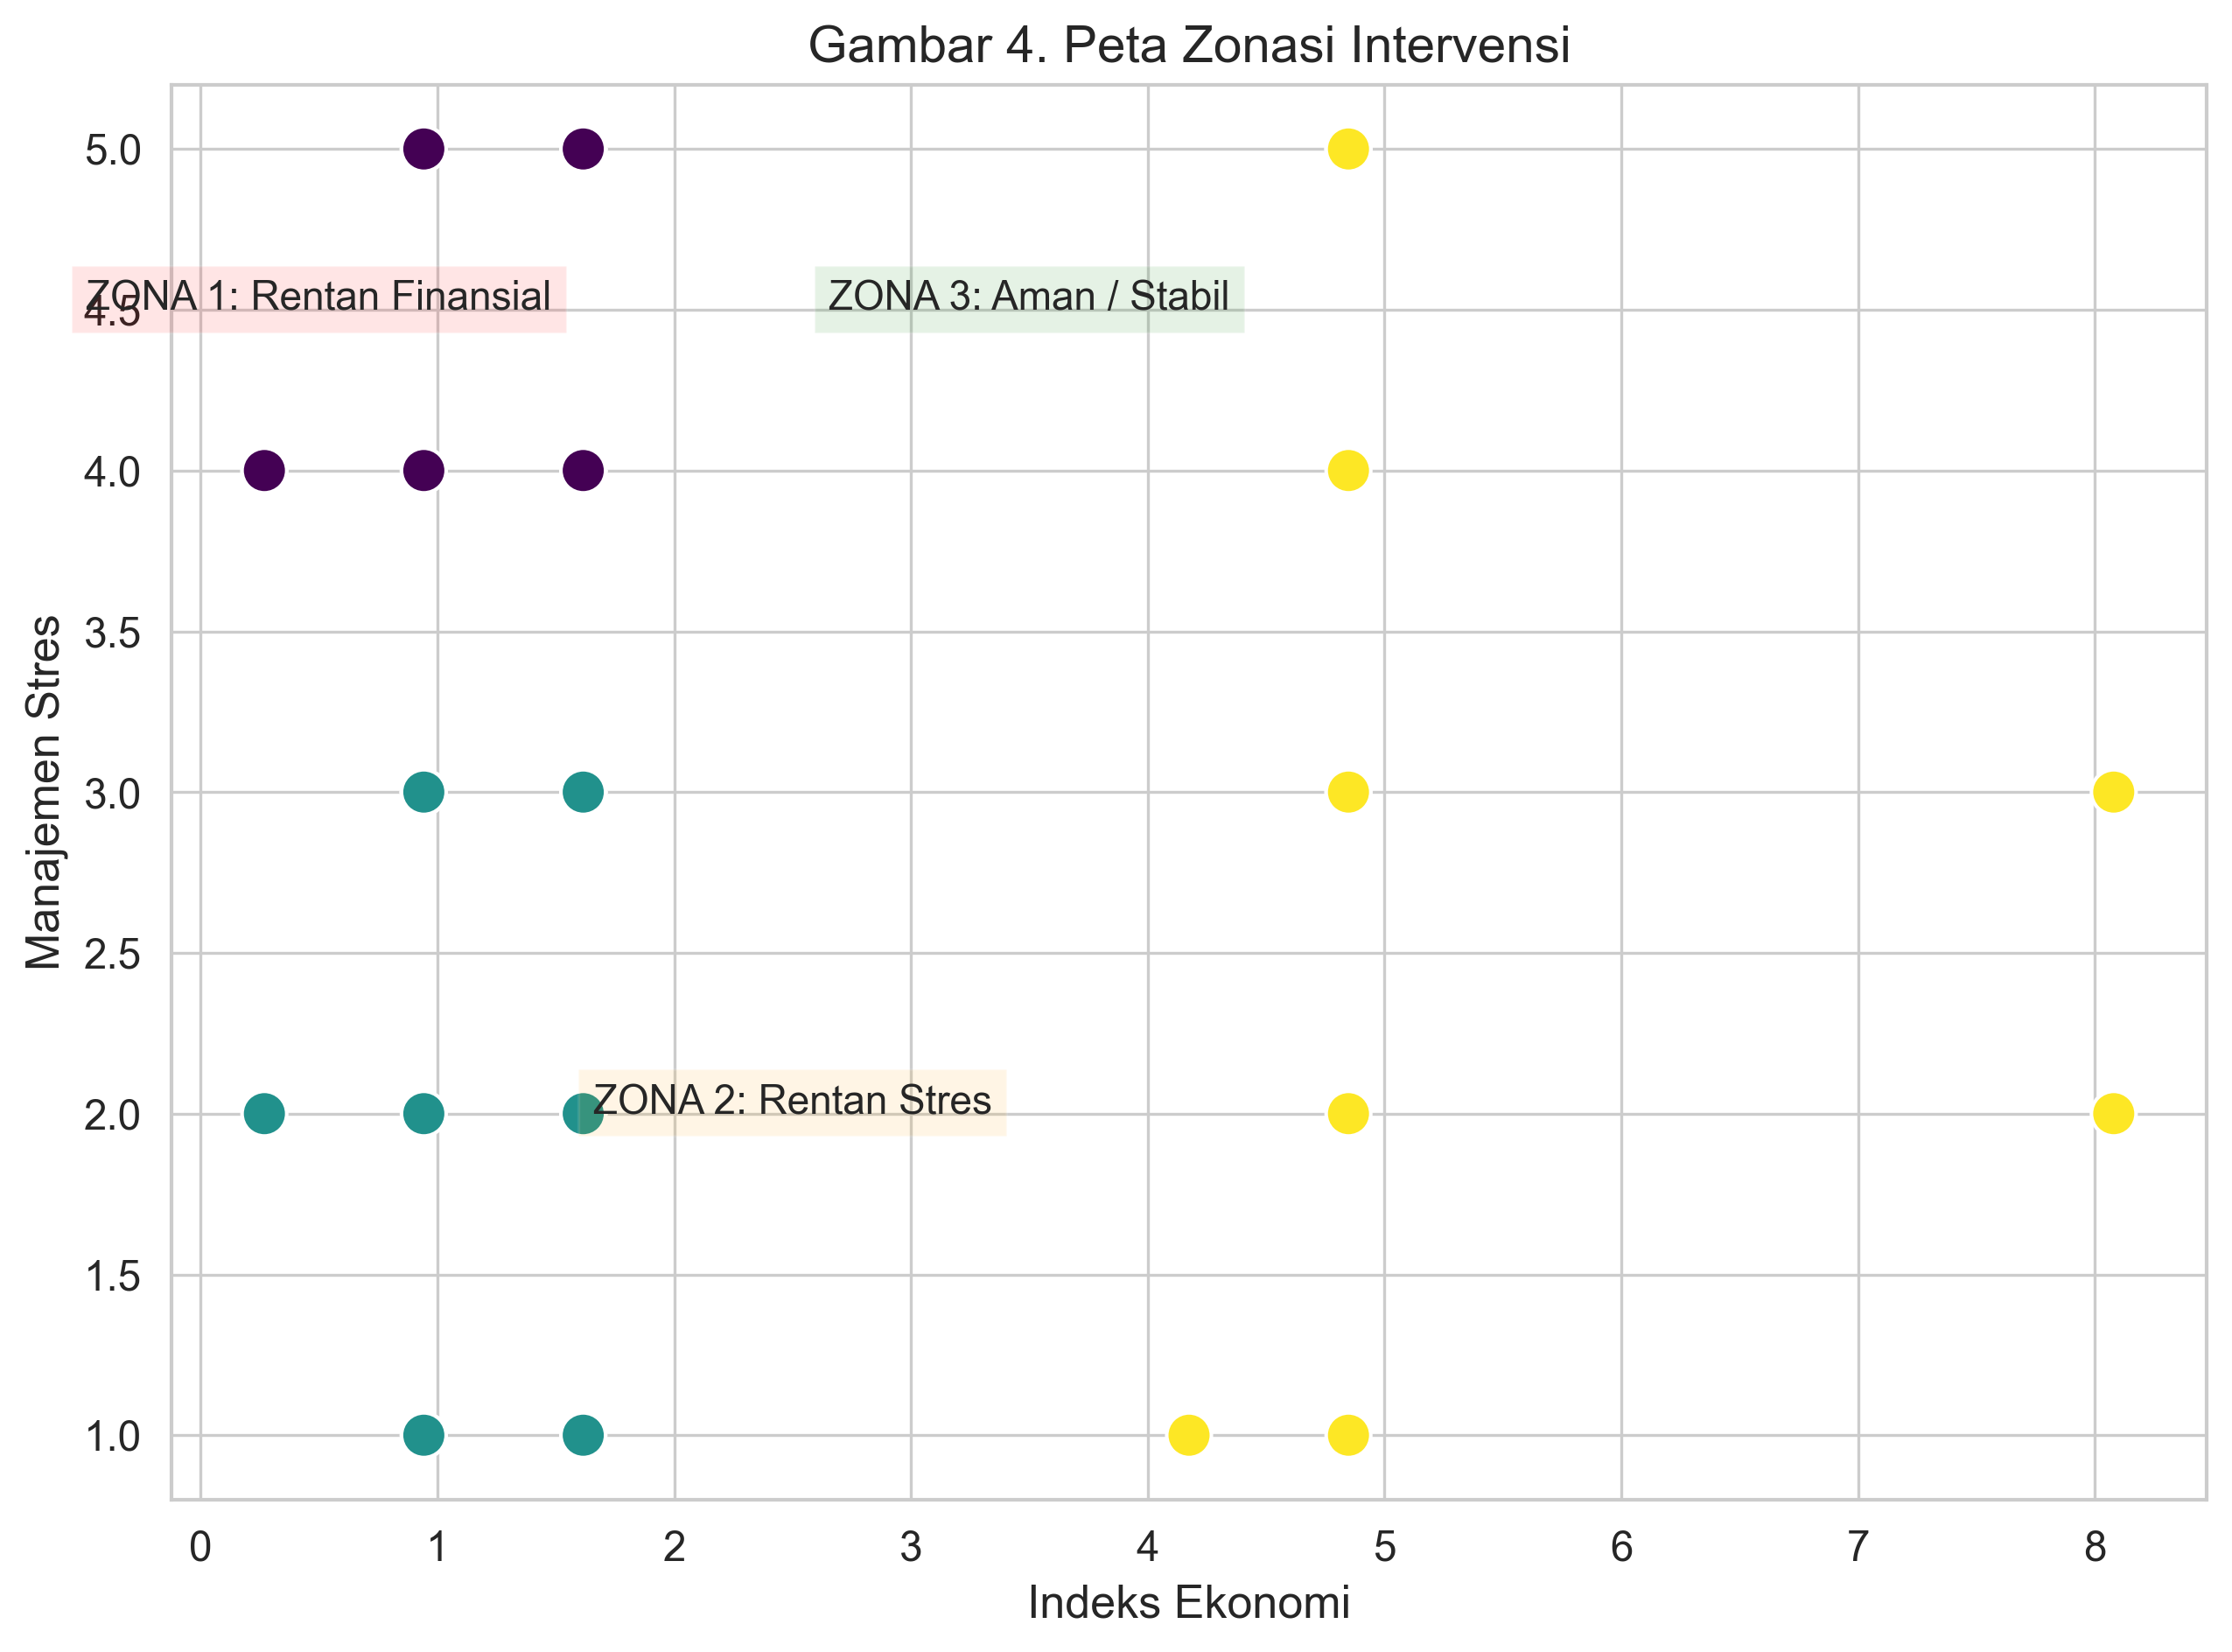

In [1]:
# =============================================================================
# SCRIPT ANALISIS RISET FINAL (FIXED ACCURACY & NAMES)
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
import warnings
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Konfigurasi Grafik
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.3)

print("🚀 [INIT] Memulai Analisis Data (Mode: Fixed)...")

# =============================================================================
# BAGIAN 1: DATA LOADING & PREPROCESSING
# =============================================================================
try:
    files = {
        'bio': 'EDA_Biodata_Lengkap.csv',
        'fin': 'EDA_Faktor_Finansial.csv',
        'wkt': 'EDA_Faktor_Komitmen_Waktu.csv',
        'blj': 'EDA_Faktor_Preferensi_Belajar.csv',
        'psi': 'EDA_Faktor_Psikologis_Kesehatan.csv',
        'kmp': 'EDA_Faktor_Kampus.csv',
        'kel': 'EDA_Faktor_Keluarga.csv'
    }
    
    dfs = []
    for key, path in files.items():
        dfs.append(pd.read_csv(path))
    
    key_col = 'Nomor Pokok Mahasiswa (NPM)'
    df_clean = dfs[0]
    for df in dfs[1:]:
        cols = df.columns.difference(df_clean.columns).tolist() + [key_col]
        df_clean = pd.merge(df_clean, df[cols], on=key_col, how='inner')

    df_clean['Program Studi (Prodi)'] = df_clean['Program Studi (Prodi)'].replace({
        'Studi Informatika': 'Informatika', 'Teknologi Informasi': 'Informatika'
    })
    df_clean = df_clean[df_clean['Program Studi (Prodi)'].isin(['Sistem Informasi', 'Informatika'])].copy()
    
    df_clean['Timestamp'] = pd.to_datetime(df_clean['Timestamp'], dayfirst=True, errors='coerce')
    df_clean = df_clean.sort_values('Timestamp', ascending=False).drop_duplicates(subset=[key_col])

    def clean_ipk(v):
        try: return float(str(v).replace(',','.').replace(' ','.'))
        except: return np.nan
    
    # PENTING: Rename kolom IPK_Clean jadi IPK agar konsisten dengan Dashboard
    df_clean['IPK'] = df_clean['IPK (skala 0.00 - 4.00)'].apply(clean_ipk)
    df_clean['IPK'].fillna(df_clean['IPK'].median(), inplace=True)

    print(f"✅ [DATA] Total Sampel Bersih: {len(df_clean)} Mahasiswa.")

except Exception as e:
    print(f"❌ [ERROR] Gagal Load Data: {e}")
    raise e

# =============================================================================
# BAGIAN 2: FEATURE ENGINEERING
# =============================================================================
GARIS_MISKIN = 928278
TANGGAL_UTS = pd.Timestamp("2025-11-20")

df_clean['Ayah_Inc'] = df_clean['Berapa pendapatan Ayah Anda per bulan?'].apply(lambda x: 15000000 if 'Lebih' in str(x) else (500000 if 'Kurang' in str(x) else 3000000))
df_clean['Ibu_Inc'] = df_clean['Berapa pendapatan Ibu Anda per bulan?'].apply(lambda x: 15000000 if 'Lebih' in str(x) else (500000 if 'Kurang' in str(x) else 3000000))
# Rename Indeks_Ekonomi -> Indeks Ekonomi (Spasi) agar Dashboard tidak bingung
df_clean['Indeks Ekonomi'] = (df_clean['Ayah_Inc'] + df_clean['Ibu_Inc']) / (GARIS_MISKIN * 4)

map_sem = {'Angkatan 2025':1, 'Angkatan 2024':3, 'Angkatan 2023':5, 'Angkatan 2022':7}
df_clean['Semester'] = df_clean['Angkatan'].map(map_sem).fillna(1)
# Rename Beban_SKS -> Beban SKS (Spasi)
df_clean['Beban SKS'] = df_clean.apply(lambda r: 23 if (r['Semester']>=3 and r['Semester']<=6) else 20, axis=1)

df_clean['Days_To_Exam'] = (TANGGAL_UTS - df_clean['Timestamp']).dt.days
df_clean['Tekanan Ujian'] = df_clean['Days_To_Exam'].apply(lambda x: 100/max(1, x) if (0 < x < 30) else 0)

# PENTING: Target Definition yang AMAN (Dynamic Threshold)
# Ini mencegah error NaN karena memastikan ada cukup sampel di kedua kelas
batas_bawah = df_clean['IPK'].quantile(0.25) # 25% Terbawah
if batas_bawah < 2.75: batas_bawah = 2.75
elif batas_bawah > 3.50: batas_bawah = 3.50

print(f"📊 [TARGET] Batas Risiko Dinamis: IPK < {batas_bawah:.2f}")
df_clean['Target'] = df_clean['IPK'].apply(lambda x: 1 if x >= batas_bawah else 0)

rename_map = {
    'Seberapa sering Anda mendapatkan dukungan dari keluarga dalam hal akademik?  ': 'Dukungan Keluarga',
    'Seberapa baik Anda mengelola stres yang berhubungan dengan perkuliahan?  ': 'Manajemen Stres',
    'Seberapa sering Anda mengalami gangguan saat belajar?': 'Gangguan Belajar',
    'Seberapa baik Anda mengelola waktu antara kuliah, pekerjaan, dan kegiatan lain?  ': 'Manajemen Waktu'
}
df_clean.rename(columns=rename_map, inplace=True)

# Gunakan Nama Kolom dengan SPASI (agar dashboard langsung baca)
features = ['Indeks Ekonomi', 'Beban SKS', 'Dukungan Keluarga', 'Manajemen Stres', 
            'Gangguan Belajar', 'Manajemen Waktu', 'Tekanan Ujian']

# =============================================================================
# BAGIAN 3: MODELING (SAFE MODE)
# =============================================================================
print("\n⚙️ [MODELING] Menjalankan Evaluasi Model...")

X = df_clean[features].fillna(0)
y = df_clean['Target']

# Cek Jumlah Sampel Minoritas
min_samples = y.value_counts().min()
# Jika sampel sangat sedikit (<6), GANTI SMOTE dengan RandomOverSampler (Duplikasi)
# RandomOverSampler lebih aman dan tidak crash kalau sampel sedikit
if min_samples < 6:
    sampler = RandomOverSampler(random_state=42)
    print("   ⚠️ Data minoritas sedikit. Menggunakan Random Oversampling (Safe Mode).")
else:
    sampler = SMOTE(random_state=42, k_neighbors=min(5, min_samples-1))
    print("   ✅ Data cukup. Menggunakan SMOTE.")

models = {
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
}

results = []
names = []

# Cross Validation yang Aman
# Gunakan n_splits minimal 2, maksimal 5 (tergantung data)
n_splits = max(2, min(5, min_samples)) 

for name, model in models.items():
    pipeline = ImbPipeline(steps=[('sampler', sampler), ('m', model)])
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    try:
        scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
        results.append(scores)
        names.append(name)
        print(f"   > {name}: Akurasi {scores.mean():.4f}")
    except Exception as e:
        print(f"   ❌ Gagal pada {name}: {e}")
        results.append([0])
        names.append(name)

# =============================================================================
# BAGIAN 4: VISUALISASI & EXPORT
# =============================================================================
print("\n🎨 [VISUAL] Membuat Grafik...")

# 1. Komparasi Model
plt.figure(figsize=(10, 6))
means = [np.mean(r) if len(r)>0 else 0 for r in results]
bars = plt.bar(names, means, color=['#e74c3c', '#f1c40f', '#2ecc71'], alpha=0.9)
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + 0.01, f"{h*100:.1f}%", ha='center', fontweight='bold')
plt.title('Gambar 1. Perbandingan Akurasi Model (Fixed)', fontsize=14)
plt.ylabel('Akurasi')
plt.savefig('Gambar1_Komparasi_Model.png')

# 2. Matriks Korelasi
plt.figure(figsize=(10, 8))
corr = df_clean[features + ['IPK']].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='RdBu_r', linewidths=1, vmin=-0.5, vmax=0.5)
plt.title('Gambar 2. Matriks Korelasi Faktor Akademik', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('Gambar2_Korelasi.png')

# 3. SHAP Analysis (Model Agnostic - 100% Aman)
final_model = models['XGBoost']
final_model.fit(X, y)
predict_fn = lambda x: final_model.predict_proba(x)[:, 1]
explainer = shap.Explainer(predict_fn, X)
shap_values = explainer(X)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X, feature_names=features, plot_type="bar", show=False, color='#34495e')
plt.title('Gambar 3. Faktor Determinan Prestasi (SHAP)', fontsize=14)
plt.tight_layout()
plt.savefig('Gambar3_SHAP_Importance.png')

# 4. Clustering Zonasi
X_clust = df_clean[['Indeks Ekonomi', 'Manajemen Stres']].copy()
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_clean['Cluster'] = kmeans.fit_predict(X_clust)

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_clean, x='Indeks Ekonomi', y='Manajemen Stres', hue='Cluster', palette='viridis', s=150, legend=False)
plt.text(0.5, 4.5, "ZONA 1: Rentan Finansial", fontsize=11, bbox=dict(facecolor='red', alpha=0.1), ha='center')
plt.text(2.5, 2.0, "ZONA 2: Rentan Stres", fontsize=11, bbox=dict(facecolor='orange', alpha=0.1), ha='center')
plt.text(3.5, 4.5, "ZONA 3: Aman / Stabil", fontsize=11, bbox=dict(facecolor='green', alpha=0.1), ha='center')
plt.title('Gambar 4. Peta Zonasi Intervensi', fontsize=14)
plt.xlabel('Indeks Ekonomi')
plt.ylabel('Manajemen Stres')
plt.savefig('Gambar4_Clustering.png')

# Simpan Data Final (Nama Kolom Sudah Benar: IPK, Indeks Ekonomi, dll)
df_clean.to_csv('processed_data_final.csv', index=False)
print("\n✅ [SELESAI] Analisis Berhasil! CSV Final Tersimpan.")